### Importing all required libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from matplotlib import pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

**Reading last 10 years of data**

Link to dataset: https://finance.yahoo.com/quote/WMT/history?p=WMT

In [2]:
dataset = pd.read_csv('WMT-10Y.csv')

In [3]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,68.930000,69.239998,68.449997,69.239998,55.454227,10390800
1,2013-01-03,69.250000,69.349998,68.379997,68.800003,55.101822,8910100
2,2013-01-04,68.730003,69.180000,68.339996,69.059998,55.310040,6438000
3,2013-01-07,68.830002,68.919998,68.129997,68.400002,54.781464,6201400
4,2013-01-08,68.279999,68.889999,68.209999,68.589996,54.933628,5866900


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2546 non-null   object 
 1   Open       2546 non-null   float64
 2   High       2546 non-null   float64
 3   Low        2546 non-null   float64
 4   Close      2546 non-null   float64
 5   Adj Close  2546 non-null   float64
 6   Volume     2546 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 139.4+ KB


As we can see above, there is no null values in the dataset which is a good thing. However, the data type of *Date* attribute is improper which we will handle ahead. 

In [5]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2.546000e+03
mean,98.857227,99.668669,98.117926,98.888162,91.272432,8.133038e+06
std,28.570193,28.889253,28.268571,28.557671,31.875054,4.594650e+06
min,56.389999,57.060001,56.299999,56.419998,48.370846,2.094900e+06
25%,74.839996,75.322500,74.449997,74.872501,63.027284,5.716775e+06
50%,87.269997,88.094997,86.570000,87.444999,79.877926,6.963200e+06
75%,125.442499,126.952500,124.382502,125.437498,123.125083,9.178100e+06
max,160.250000,160.770004,159.070007,159.869995,158.004608,8.089810e+07


We can see the *maximum* closing stock price in past years is `159.87`.

In [6]:
dataset['Date'] = pd.to_datetime(dataset['Date']) # Converting object type to datatime

In [7]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,68.930000,69.239998,68.449997,69.239998,55.454227,10390800
1,2013-01-03,69.250000,69.349998,68.379997,68.800003,55.101822,8910100
2,2013-01-04,68.730003,69.180000,68.339996,69.059998,55.310040,6438000
3,2013-01-07,68.830002,68.919998,68.129997,68.400002,54.781464,6201400
4,2013-01-08,68.279999,68.889999,68.209999,68.589996,54.933628,5866900


Uncomment below cell for interactive graph and candle sticks for the dataset

In [8]:
'''fig = go.Figure(data=[go.Candlestick(x=dataset['Date'],
                open=dataset['Open'],
                high=dataset['High'],
                low=dataset['Low'],
                close=dataset['Close'])])

fig.show()'''
# Interactive candle plot

"fig = go.Figure(data=[go.Candlestick(x=dataset['Date'],\n                open=dataset['Open'],\n                high=dataset['High'],\n                low=dataset['Low'],\n                close=dataset['Close'])])\n\nfig.show()"

**Plotting opening price**

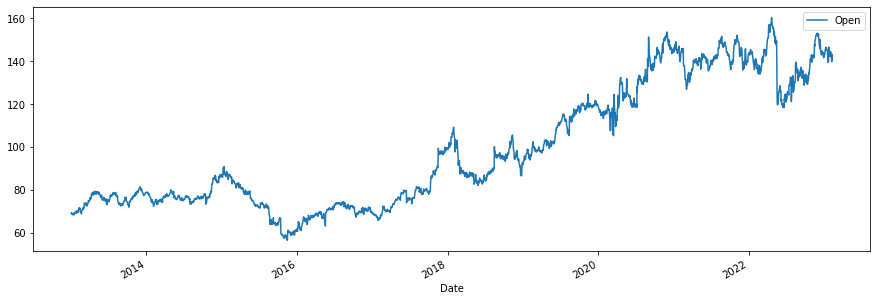

In [9]:
walmart_dataset = dataset.set_index('Date') # date as index
walmart_dataset.plot(y='Open', figsize=(15,5))
plt.show()

As we can see, the stock price of walmart is increasing seasonally.

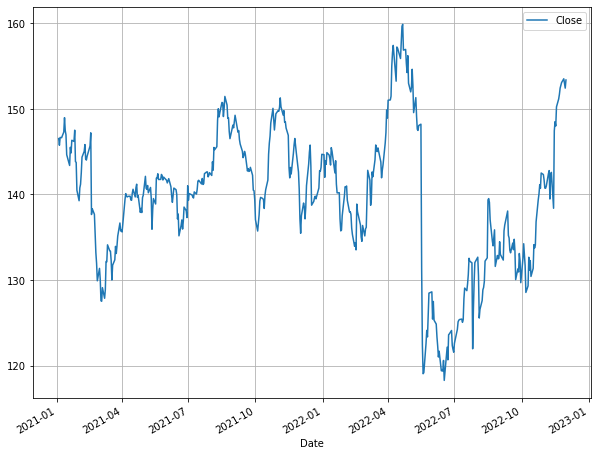

In [10]:
start_date = datetime(2021, 1, 1)
end_date = datetime(2022, 12, 1)

walmart_dataset[ (start_date <= walmart_dataset.index) & (end_date >= walmart_dataset.index)].plot(y='Close', figsize=(10,8), grid='on')
plt.show()

In [11]:
train = walmart_dataset.loc[walmart_dataset.index < '2021-01-01']
test = walmart_dataset.loc[walmart_dataset.index >= '2021-01-01']

In [12]:
train.shape, test.shape

((2015, 6), (531, 6))

### Plotting Train test data

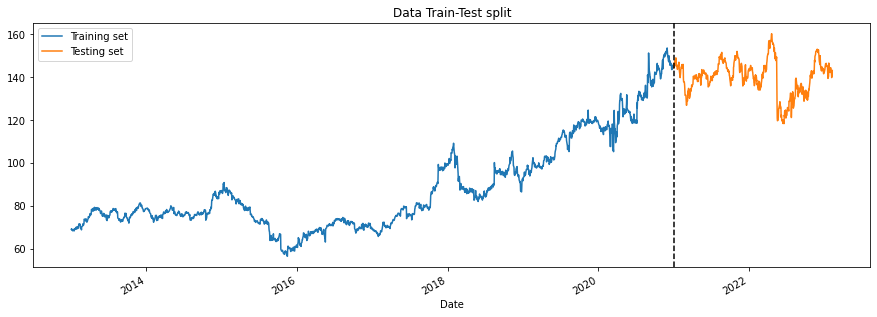

In [13]:
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, y='Open', label = 'Training set', title='Data Train-Test split')
test.plot(ax = ax, y='Open', label = 'Testing set')
ax.axvline('2021-01-01', color = 'black', ls='--')
ax.legend(['Training set', 'Testing set'])
plt.show()

## Time series analysis

### Checking weekly stock trend

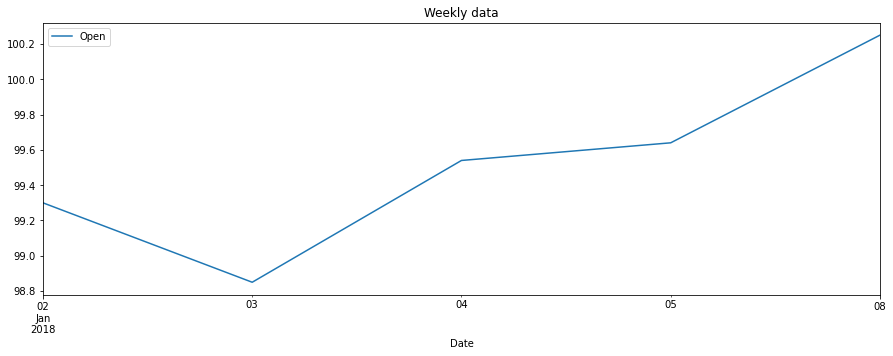

In [14]:
# Week data
walmart_dataset.loc[(walmart_dataset.index >= '2018-01-01') & (walmart_dataset.index <= '2018-01-08')].plot(figsize = (15,5),
                                                                                                          y = 'Open',
                                                                                                         title = 'Weekly data')
plt.show()

In [15]:
def create_features(walmart_dataset):
    walmart_dataset['quarter'] = walmart_dataset.index.quarter
    walmart_dataset['month'] = walmart_dataset.index.month
    walmart_dataset['year'] = walmart_dataset.index.year
    walmart_dataset['dayofyear'] = walmart_dataset.index.dayofyear
    return walmart_dataset

In [16]:
walmart_dataset = create_features(walmart_dataset)

In [17]:
walmart_dataset.head()

,Open,High,Low,Close,Adj Close,Volume,quarter,month,year,dayofyear
Date,,,,,,,,,,
2013-01-02,68.930000,69.239998,68.449997,69.239998,55.454227,10390800,1,1,2013,2
2013-01-03,69.250000,69.349998,68.379997,68.800003,55.101822,8910100,1,1,2013,3
2013-01-04,68.730003,69.180000,68.339996,69.059998,55.310040,6438000,1,1,2013,4
2013-01-07,68.830002,68.919998,68.129997,68.400002,54.781464,6201400,1,1,2013,7
2013-01-08,68.279999,68.889999,68.209999,68.589996,54.933628,5866900,1,1,2013,8


### Monthly stock price

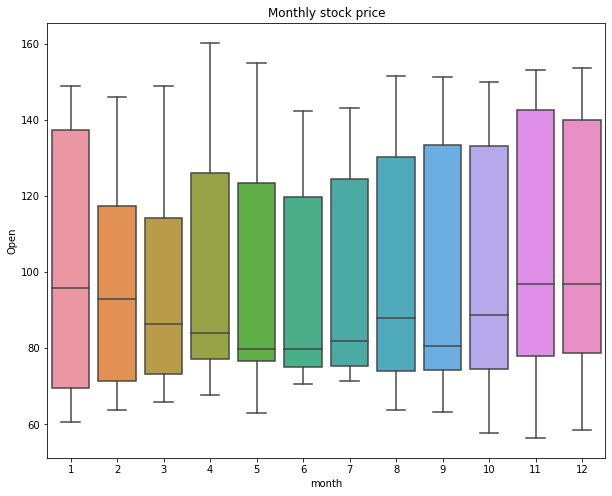

In [18]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = walmart_dataset, x='month', y='Open')
ax.set_title('Monthly stock price')
plt.show()

In winter the stock price seems to be increasing.

### Quarterly stock price

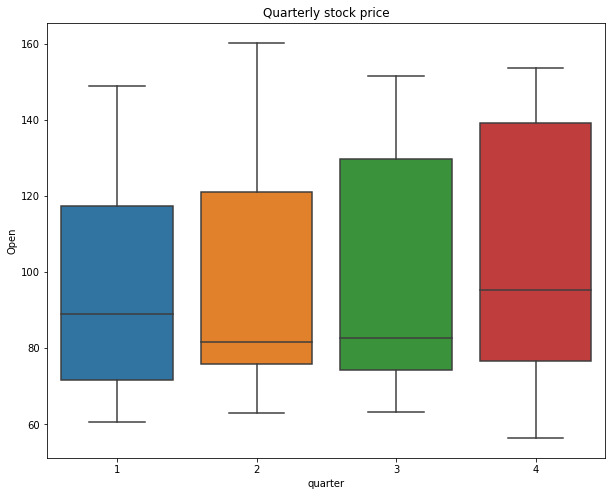

In [19]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = walmart_dataset, x='quarter', y='Open')
ax.set_title('Quarterly stock price')
plt.show()

### Yearly stock price

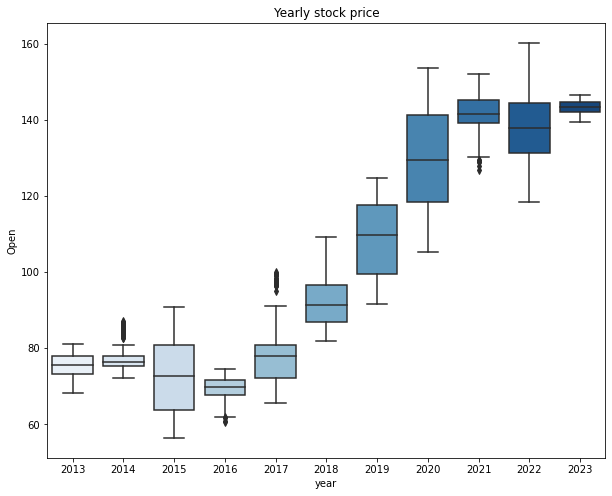

In [20]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = walmart_dataset, x='year', y='Open', palette = 'Blues')
ax.set_title('Yearly stock price')
plt.show()

In 2019 and 2020, just before covid and during covid the stock prices increased heavily.

## Preparing dataset for model training

In [21]:
X = walmart_dataset.iloc[:,0:3]
y = walmart_dataset['Close']

**Normalizing the dataset**

In [22]:
cols = X.columns
ind = X.index
sc = StandardScaler()
X = sc.fit_transform(X.values)
X = pd.DataFrame(columns = cols, data = X, index = ind)

### Train test split

In [23]:
def lstm_split(dataset_features, dataset_labels, n_steps):
    X, y = [], []
    for i in range(len(dataset) - n_steps + 1):
        X.append(dataset_features[i:i + n_steps])
        y.append(dataset_labels[i + n_steps - 1])
    return np.array(X), np.array(y)

 we take two steps worth of past data to predict the current value. Thus, the model will look at yesterday’s and today’s values to predict today’s closing price.
 Also, this is a time series problem we **`must not shuffle`** the data

In [ ]:
X, y = lstm_split(X, y, 2)

train_split = 0.8 # 80:20 ratio
split_idx = int(np.ceil(len(X) * train_split))

X_train, X_test, = X[:split_idx], X[split_idx:]
y_train, y_test, = y[:split_idx], y[split_idx:]

In [25]:
X_train.shape, y_train.shape

((2036, 2, 3), (2036,))

In [26]:
X_test.shape, y_test.shape

((509, 2, 3), (509,))

## LSTM Model

In [27]:
lstm = Sequential()
lstm.add(LSTM(50, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(50, activation = 'relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [28]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 50)             10800     
_________________________________________________________________
dropout (Dropout)            (None, 2, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [29]:
lstm_model = lstm.fit(X_train, y_train, epochs = 60, batch_size = 16, shuffle = False)

Epoch 1/60
128/128 [==============================] - 1s 4ms/step - loss: 7840.8623
Epoch 2/60
128/128 [==============================] - 0s 4ms/step - loss: 3105.0457
Epoch 3/60
128/128 [==============================] - 0s 4ms/step - loss: 1802.8425
Epoch 4/60
128/128 [==============================] - 1s 4ms/step - loss: 1137.5244
Epoch 5/60
128/128 [==============================] - 1s 4ms/step - loss: 642.1011
Epoch 6/60
128/128 [==============================] - 1s 4ms/step - loss: 453.4568
Epoch 7/60
128/128 [==============================] - 1s 4ms/step - loss: 241.9530
Epoch 8/60
128/128 [==============================] - 1s 4ms/step - loss: 168.4427
Epoch 9/60
128/128 [==============================] - 1s 4ms/step - loss: 143.9506
Epoch 10/60
128/128 [==============================] - 1s 4ms/step - loss: 136.6434
Epoch 11/60
128/128 [==============================] - 1s 4ms/step - loss: 127.9886
Epoch 12/60
128/128 [==============================] - 1s 4ms/step - loss: 118.62

### Learning curve

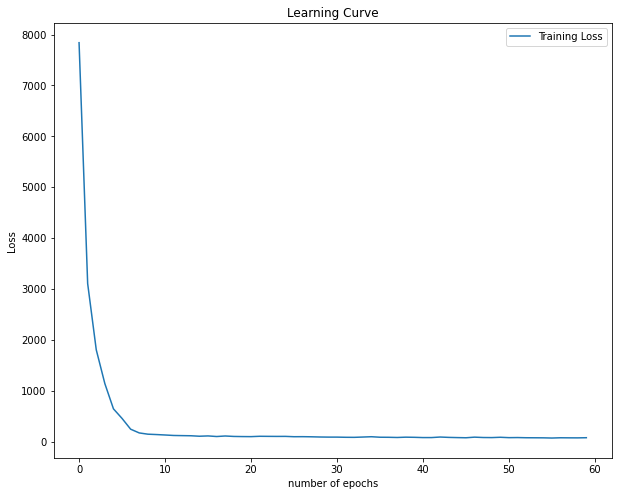

In [30]:
plt.figure(figsize = (10,8))
plt.plot([i for i in range(0,60)], lstm_model.history['loss'])
plt.title('Learning Curve')
plt.xlabel('number of epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss'])
plt.show()

### Testing the model

In [32]:
y_pred = lstm.predict(X_test)

### Testing RMSE and MAPE errors

In [33]:
rmse =  mean_squared_error(y_test, y_pred, squared = False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('RMSE score on test dataset:',rmse)
print('MAPE score on test dataset:',mape)

RMSE score on test dataset: 2.869180365553801
MAPE score on test dataset: 0.015821550375964367


## Actual stock price and Predicted stock price

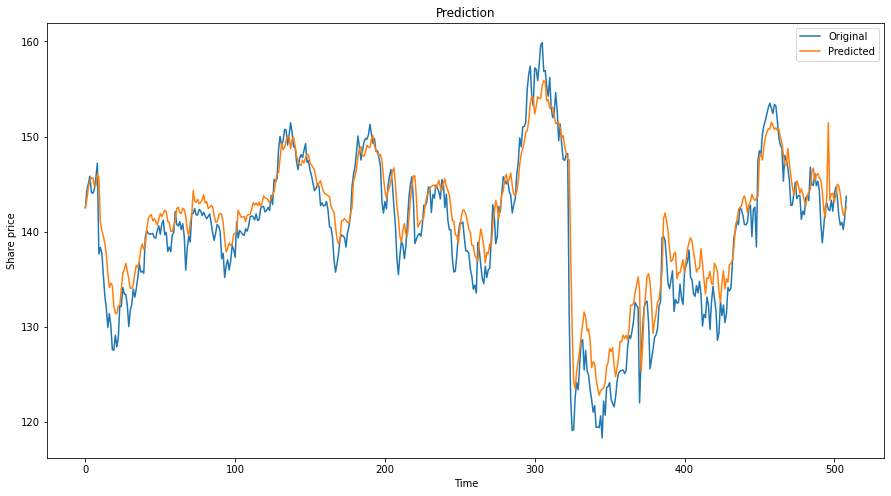

In [34]:
plt.figure(figsize = (15,8))
plt.plot(y_test, label = 'Original')
plt.plot(y_pred, label = 'Predicted')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Share price')
plt.legend()
plt.show()